Applying SVM after dimensionality reduction by PCA.

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


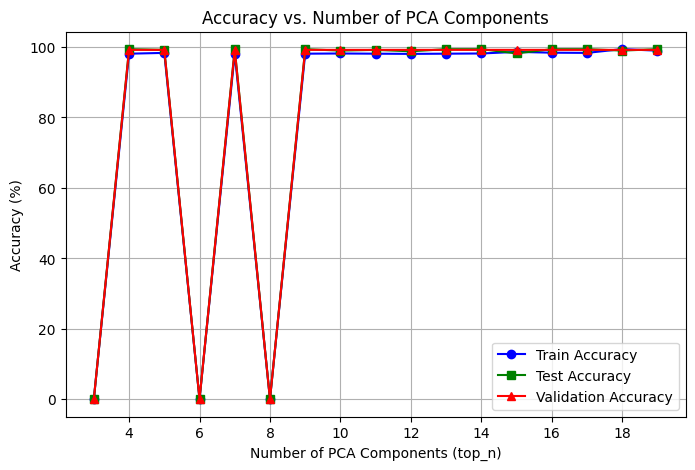

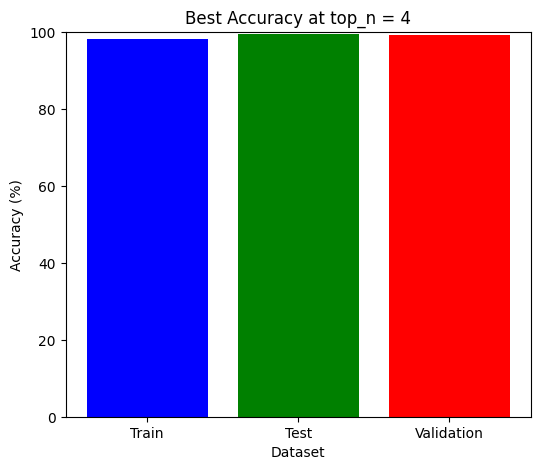

Best top_n: 4
Train Accuracy: 98.12%
Test Accuracy: 99.40%
Validation Accuracy: 99.21%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load Data
X = np.load("X_features.npy")  # MFCC features
y = np.load("y_labels.npy")    # Labels

# Standardisation
def standardise_data(dataset):
    mean = np.mean(dataset, axis=0)
    std_dev = np.std(dataset, axis=0) + 1e-8  # Avoid division by zero
    return (dataset - mean) / std_dev

# PCA Computation (Eigenvector Selection)
def compute_pca(X, top_n):
    cov_matrix = np.cov(X, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues, eigenvectors = eigenvalues[sorted_indices], eigenvectors[:, sorted_indices]

    return X @ eigenvectors[:, :top_n]

# Convert Labels to {-1, 1} for SVM
def process_labels(y):
    unique_classes = np.unique(y)
    return np.where(y == unique_classes[0], -1, 1)  # Binary classification

# Standardize Data
X_std = standardise_data(X)
y_binary = process_labels(y)

#Dataset Splitting
#I have used a 70-20-10 Train-Test-Validation Split
X_train_full, X_temp, y_train_full, y_temp = train_test_split(X_std, y_binary, test_size=0.30, random_state=42)
X_test_full, X_val_full, y_test_full, y_val_full = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

#SVM Implementation
class SVM:
    def __init__(self, C=1.0, lr=0.001, tol=1e-4, max_iter=500, batch_size=512):
        self.C = C
        self.lr = lr
        self.tol = tol
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.w = None
        self.b = 0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.max_iter):
            indices = np.random.permutation(n_samples)
            for i in range(0, n_samples, self.batch_size):
                X_batch = X[indices[i:i+self.batch_size]]
                y_batch = y[indices[i:i+self.batch_size]]

                margin = y_batch * (np.dot(X_batch, self.w) + self.b)
                mask = margin < 1  # Support vectors

                grad_w = np.mean(-y_batch[mask, None] * X_batch[mask], axis=0) + self.C * self.w
                grad_b = np.mean(-y_batch[mask])

                self.w -= self.lr * grad_w
                self.b -= self.lr * grad_b

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

# Accuracy Calculation
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100

# Store results
top_n_values = list(range(3, 20))
train_accuracies = []
test_accuracies = []
val_accuracies = []

best_top_n = None
best_test_acc = 0

# Iterate over different top_n values
for top_n in top_n_values:
    # Applying PCA
    X_train = compute_pca(X_train_full, top_n)
    X_test = compute_pca(X_test_full, top_n)
    X_val = compute_pca(X_val_full, top_n)

    # Training SVM Model
    svm_model = SVM(C=1.0, lr=0.001, tol=1e-4, max_iter=500, batch_size=512)
    svm_model.fit(X_train, y_train_full)

    #Predicting values from SVM Trained data
    y_train_pred = svm_model.predict(X_train)
    y_test_pred = svm_model.predict(X_test)
    y_val_pred = svm_model.predict(X_val)

    # Compute accuracies
    train_acc = accuracy(y_train_full, y_train_pred)
    test_acc = accuracy(y_test_full, y_test_pred)
    val_acc = accuracy(y_val_full, y_val_pred)

    # Store results
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    val_accuracies.append(val_acc)

    # Track best test accuracy
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_top_n = top_n

# Plot accuracy vs top_n
plt.figure(figsize=(8, 5))
plt.plot(top_n_values, train_accuracies, marker='o', label="Train Accuracy", color="blue")
plt.plot(top_n_values, test_accuracies, marker='s', label="Test Accuracy", color="green")
plt.plot(top_n_values, val_accuracies, marker='^', label="Validation Accuracy", color="red")
plt.xlabel("Number of PCA Components (top_n)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Number of PCA Components")
plt.legend()
plt.grid(True)
plt.show()

# Bar chart for the best top_n
plt.figure(figsize=(6, 5))
plt.bar(["Train", "Test", "Validation"],
        [train_accuracies[top_n_values.index(best_top_n)],
         test_accuracies[top_n_values.index(best_top_n)],
         val_accuracies[top_n_values.index(best_top_n)]],
        color=['blue', 'green', 'red'])
plt.xlabel("Dataset")
plt.ylabel("Accuracy (%)")
plt.title(f"Best Accuracy at top_n = {best_top_n}")
plt.ylim(0, 100)
plt.show()

# Print results
best_index = top_n_values.index(best_top_n)
print(f"Best top_n: {best_top_n}")
print(f"Train Accuracy: {train_accuracies[best_index]:.2f}%")
print(f"Test Accuracy: {best_test_acc:.2f}%")
print(f"Validation Accuracy: {val_accuracies[best_index]:.2f}%")